# Simple Boosting Experiment

(569, 30)
(569,)
Class 0:  0.373
Class 1:  0.627


<IPython.core.display.Javascript object>


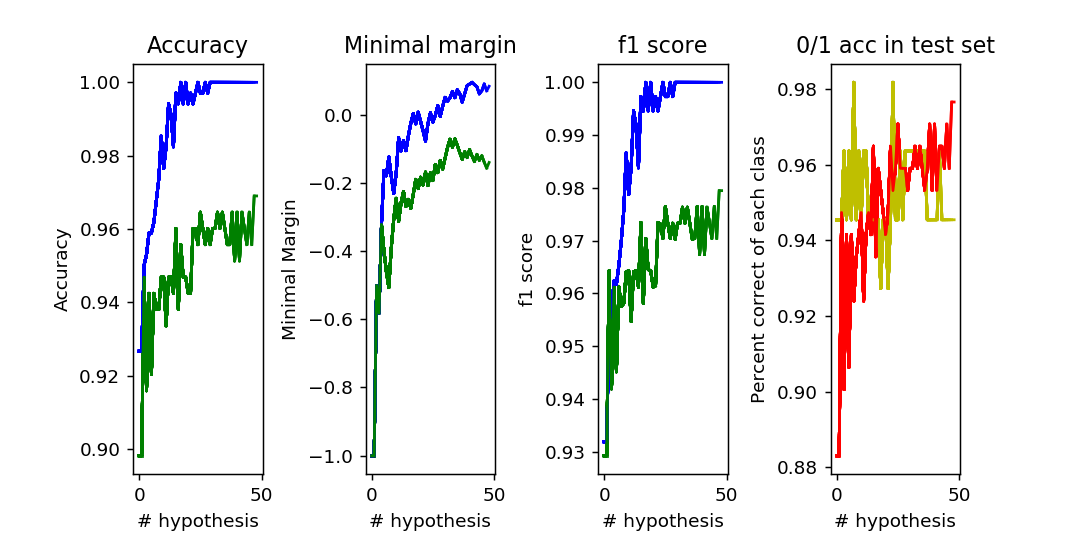

Iter.	acc_train  acc_test   mm_in      mm_test    f1_train   f1_test    acc0_test  acc1_test 
1 	0.926686   0.898230   -1.000000  -1.000000  0.931880   0.929231   0.945455   0.883041   
2 	0.926686   0.898230   -1.000000  -1.000000  0.931880   0.929231   0.945455   0.883041   
3 	0.950147   0.946903   -0.500860  -0.500860  0.954667   0.964286   0.945455   0.947368   
4 	0.953079   0.915929   -0.581895  -0.581895  0.956044   0.941896   0.963636   0.900585   
5 	0.958944   0.942478   -0.321698  -0.321698  0.962366   0.961194   0.945455   0.941520   
6 	0.958944   0.920354   -0.164583  -0.398407  0.961749   0.945122   0.963636   0.906433   
7 	0.961877   0.942478   -0.179259  -0.461151  0.965333   0.961194   0.945455   0.941520   
8 	0.967742   0.938053   -0.124598  -0.507033  0.970027   0.957576   0.981818   0.923977   
9 	0.973607   0.938053   -0.181166  -0.391147  0.975741   0.958084   0.945455   0.935673   
10 	0.985337   0.946903   -0.230771  -0.306870  0.986595   0.964072   0.963636

In [156]:
%matplotlib notebook

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import make_classification
from sklearn.datasets import make_hastie_10_2

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

def test(X_train, X_test, y_train, y_test, ada): 
    # compute in+out of sample error
    # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier.score
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
        # Source Code (binary case): 
        # score = (y_true == y_pred)
        # return _weighted_sum(score, sample_weight, normalize)
    acc_train = ada.score(X_train, y_train)
    acc_test  = ada.score(X_test, y_test)
    
    # accuracy on each class in test set 
    # this is actually recall; look at the x's that have label 'i', how many of those are predicted label 'i'?
    acc0_test = ada.score(X_test[y_test == 0], np.zeros(sum(y_test==0)))
    acc1_test = ada.score(X_test[y_test == 1], np.ones(sum(y_test==1)))
    
    # compute in+out margin; margin is unsigned hypothesis * label:  (sum_i a_ih_i(x))*y
    # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier.decision_function
    # https://github.com/scikit-learn/scikit-learn/blob/f3320a6f/sklearn/ensemble/weight_boosting.py#L641
        # Source Code (binary case)
        # classes = ? [0: 2]?
        # pred = sum((estimator.predict(X) == classes).T * w for estimator, w in zip(self.estimators_, self.estimator_weights_))
        # pred /= self.estimator_weights_.sum()
    H_train = ada.decision_function(X_train)
    H_test  = ada.decision_function(X_test)
    mm_train = np.min(H_train * (y_train*2-1))
    mm_test  = np.min(H_test  * (y_test *2-1))

    # compute in+out precision recall. 2*(p*r/(p+r))
    f1_train = f1_score(y_train, ada.predict(X_train))
    f1_test  = f1_score(y_test, ada.predict(X_test))
    
    return acc_train, acc_test, mm_train, mm_test, f1_train, f1_test, acc0_test, acc1_test

def ada_boost(X, y, depth, estimators):
    n, d = X.shape
    
    split = int(n*0.6)
    
    X_train = X[:split]
    y_train = y[:split]
    X_test  = X[split+1: -1]
    y_test  = y[split+1: -1]

    # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    # Algorithm from: https://web.stanford.edu/~hastie/Papers/samme.pdf
    # Generalization of adaboost to handle 2 -> k classes. This is not used here, but 
    # they comment "It is worth noting that when K=2, SAMME reduces to AdaBoost. " 
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth),  algorithm="SAMME", n_estimators=estimators)
    ada.fit(X_train, y_train)
    
    # Todo: Try adaboost variations that provably maximizes minimal margin.
    # ..

    return [test(X_train, X_test, y_train, y_test, ada), ada]

def experiment(X, y, depth=1, interval=range(1, 100)): 
    # visualization stuff
    plot_acc_train  = []
    plot_acc_test   = []
    plot_mm_train = []
    plot_mm_test  = []
    plot_f1_train = []
    plot_f1_test  = []
    plot_acc0_test = []
    plot_acc1_test = []

    fig, (ax_acc, ax_margin, ax_f1, ax_acc01) = plt.subplots(1, 4, figsize=(8,4)) 
    fig.subplots_adjust(wspace=.8) #width space between subplots
    # end visualization stuff. 

    print("Iter.\t%-10s %-10s %-10s %-10s %-10s %-10s %-10s %-10s"%
          ("acc_train", "acc_test", "mm_in", "mm_test", "f1_train", "f1_test", "acc0_test", "acc1_test"))
    for i in interval:
        vals = ada_boost(X, y, depth, i)[0]
        print(i, "\t%-10f %-10f %-10f %-10f %-10f %-10f %-10f %-10f "%(vals))
        plot_acc_train.append(vals[0])
        plot_acc_test.append(vals[1])
        plot_mm_train.append(vals[2])
        plot_mm_test.append(vals[3])
        plot_f1_train.append(vals[4])
        plot_f1_test.append(vals[5])
        plot_acc0_test.append(vals[6])
        plot_acc1_test.append(vals[7])

        ax_acc.plot(plot_acc_train, color='b')
        ax_acc.plot(plot_acc_test, color='g')
        ax_acc.set_title("Accuracy")
        ax_acc.set_xlabel("# hypothesis")
        ax_acc.set_ylabel("Accuracy")

        ax_margin.plot(plot_mm_train, color='b')
        ax_margin.plot(plot_mm_test, color='g')
        ax_margin.set_title("Minimal margin")
        ax_margin.set_xlabel("# hypothesis")
        ax_margin.set_ylabel("Minimal Margin")

        ax_f1.plot(plot_f1_train, color='b')
        ax_f1.plot(plot_f1_test, color='g')
        ax_f1.set_title("f1 score")
        ax_f1.set_xlabel("# hypothesis")
        ax_f1.set_ylabel("f1 score")

        ax_acc01.plot(plot_acc0_test, color='y')
        ax_acc01.plot(plot_acc1_test, color='r')
        ax_acc01.set_title("0/1 acc in test set")
        ax_acc01.set_xlabel("# hypothesis")
        ax_acc01.set_ylabel("Percent correct of each class")

        fig.canvas.draw()

# real dataset
X, y = load_breast_cancer(True)

print(X.shape)
print(y.shape)
print("Class 0: ", round(sum(y==0)/y.size, 3))
print("Class 1: ", round(sum(y==1)/y.size, 3))

depth = 1
interval = range(1, 50)
experiment(X, y, depth, interval)

The following defines multiple experiments with 3 different real datasets and 2 different generated datasets. See links in the code for documentation of both real and generated data. All data is randomly permuted before the experiments are run; in some cases, this might cause a mistake (this is very unlikely, just run code again). 

(1000, 20)
(1000,)
Class 0:  0.498
Class 1:  0.502


<IPython.core.display.Javascript object>


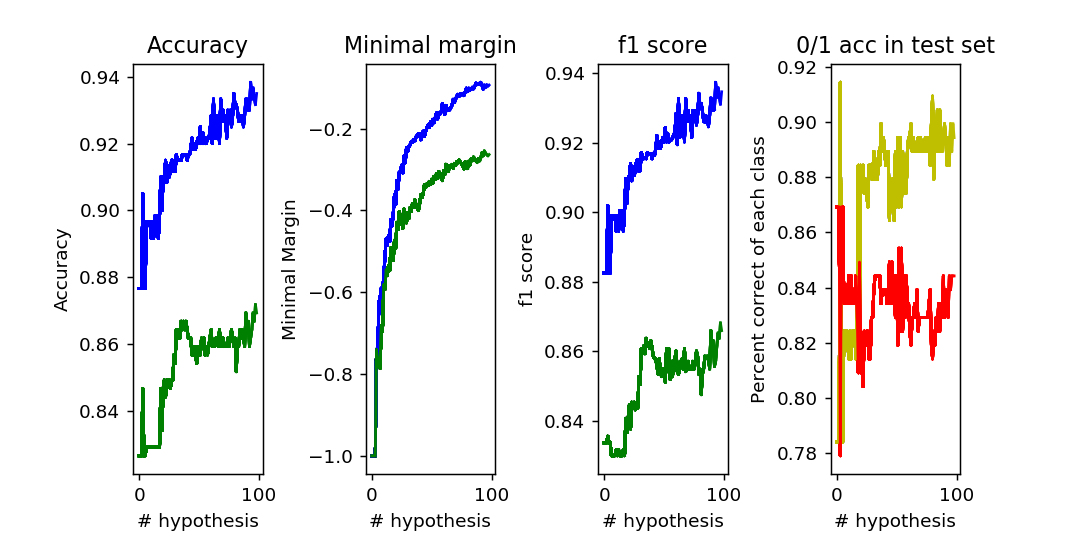

Iter.	acc_train  acc_test   mm_in      mm_test    f1_train   f1_test    acc0_test  acc1_test 
1 	0.876667   0.826633   -1.000000  -1.000000  0.882540   0.833735   0.783920   0.869347   
2 	0.876667   0.826633   -1.000000  -1.000000  0.882540   0.833735   0.783920   0.869347   
3 	0.876667   0.826633   -1.000000  -1.000000  0.882540   0.833735   0.783920   0.869347   
4 	0.905000   0.846734   -1.000000  -1.000000  0.901893   0.835580   0.914573   0.778894   
5 	0.876667   0.826633   -0.739550  -0.739550  0.882540   0.833735   0.783920   0.869347   
6 	0.876667   0.826633   -0.762054  -0.762054  0.882540   0.833735   0.783920   0.869347   
7 	0.896667   0.829146   -0.625025  -0.782783  0.899023   0.830000   0.824121   0.834171   
8 	0.896667   0.829146   -0.614034  -0.785825  0.899023   0.830000   0.824121   0.834171   
9 	0.896667   0.829146   -0.590197  -0.681620  0.899023   0.830000   0.824121   0.834171   
10 	0.896667   0.829146   -0.608296  -0.695682  0.899023   0.830000   0.824121

89 	0.928333   0.859296   -0.091983  -0.282149  0.927731   0.854922   0.889447   0.829146   
90 	0.933333   0.869347   -0.089351  -0.273179  0.932886   0.865979   0.894472   0.844221   
91 	0.933333   0.864322   -0.091326  -0.278721  0.932432   0.859375   0.899497   0.829146   
92 	0.930000   0.866834   -0.086430  -0.271226  0.929293   0.863049   0.894472   0.839196   
93 	0.930000   0.859296   -0.094231  -0.258838  0.929530   0.855670   0.884422   0.834171   
94 	0.938333   0.861809   -0.103495  -0.266419  0.937394   0.857143   0.894472   0.829146   
95 	0.933333   0.864322   -0.093008  -0.254384  0.933110   0.861538   0.884422   0.844221   
96 	0.936667   0.869347   -0.099221  -0.259491  0.935811   0.865285   0.899497   0.839196   
97 	0.933333   0.866834   -0.092544  -0.263590  0.933110   0.863753   0.889447   0.844221   
98 	0.931667   0.871859   -0.095725  -0.266171  0.931092   0.868217   0.899497   0.844221   
99 	0.935000   0.869347   -0.093072  -0.263105  0.934673   0.865979   

In [192]:
def breast(depth=1, interval=range(1,100)):
    #http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer
    X, y = load_breast_cancer(True)
    
    # randomly permute data. 
    p = np.random.permutation(y.size)
    X = X[p]
    y = y[p]
    
    # print size and information of class sizes. 
    print(X.shape)
    print(y.shape)
    print("Class 0: ", round(sum(y==0)/y.size, 3))
    print("Class 1: ", round(sum(y==1)/y.size, 3))

    experiment(X, y, depth, interval)

# Too easy. 
def iris(depth=1, interval=range(1, 100)):
    # http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris
    X, y = load_iris(True) # remove 3 class
    X = X[y!=2]
    y = y[y!=2]
    
    # randomly permute data. 
    p = np.random.permutation(y.size)
    X = X[p]
    y = y[p]
    
    # print size and information of class sizes. 
    print(X.shape)
    print(y.shape)
    print("Class 0: ", round(sum(y==0)/y.size, 3))
    print("Class 1: ", round(sum(y==1)/y.size, 3))

    experiment(X, y, depth, interval)

def wine(depth=1, interval=range(1, 100)):
    # http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine
    X, y = load_wine(True) # remove 3 class
    X = X[y!=2]
    y = y[y!=2]
    
    # randomly permute data. 
    p = np.random.permutation(y.size)
    X = X[p]
    y = y[p]
    
    # print size and information of class sizes. 
    print(X.shape)
    print(y.shape)
    print("Class 0: ", round(sum(y==0)/y.size, 3))
    print("Class 1: ", round(sum(y==1)/y.size, 3))

    experiment(X, y, depth, interval)

def random(depth=1, interval=range(1, 100), n=1000, d=20):
    # http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification
    
    X, y = make_classification(n, d, n_classes=2)
    
    # print size and information of class sizes.
    print(X.shape)
    print(y.shape)
    print("Class 0: ", round(sum(y==0)/y.size, 3))
    print("Class 1: ", round(sum(y==1)/y.size, 3))

    experiment(X, y, depth, interval)

def hastie(depth=1, interval=range(1, 100), n=1000):
    # http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_hastie_10_2.html#sklearn.datasets.make_hastie_10_2
    X, y = make_hastie_10_2(n_samples = n)
    y[y==-1] = 0 # change from {-1, 1} to {0, 1}
    
    # print size and information of class sizes.
    print(X.shape)
    print(y.shape)
    print("Class 0: ", round(sum(y==0)/y.size, 3))
    print("Class 1: ", round(sum(y==1)/y.size, 3))

    experiment(X, y, depth, interval)

#breast()
#iris()
#wine()
#random()
#random(depth=3, interval=range(1, 250, 5), n=10000, d=100) # d=50
#hastie()

Random Sample experiment

(1000, 30)
(1000,)
Class 0:  0.501
Class 1:  0.499
Name	acc_train  acc_test   mm_in      mm_test    f1_train   f1_test    acc0_test  acc1_test 
Ada10 	0.940000   0.939698   -0.462634  -0.593018  0.941176   0.937824   0.936893   0.942708   
Ada500 	1.000000   0.937186   0.042314   -0.145391  1.000000   0.934383   0.946602   0.927083   


<IPython.core.display.Javascript object>


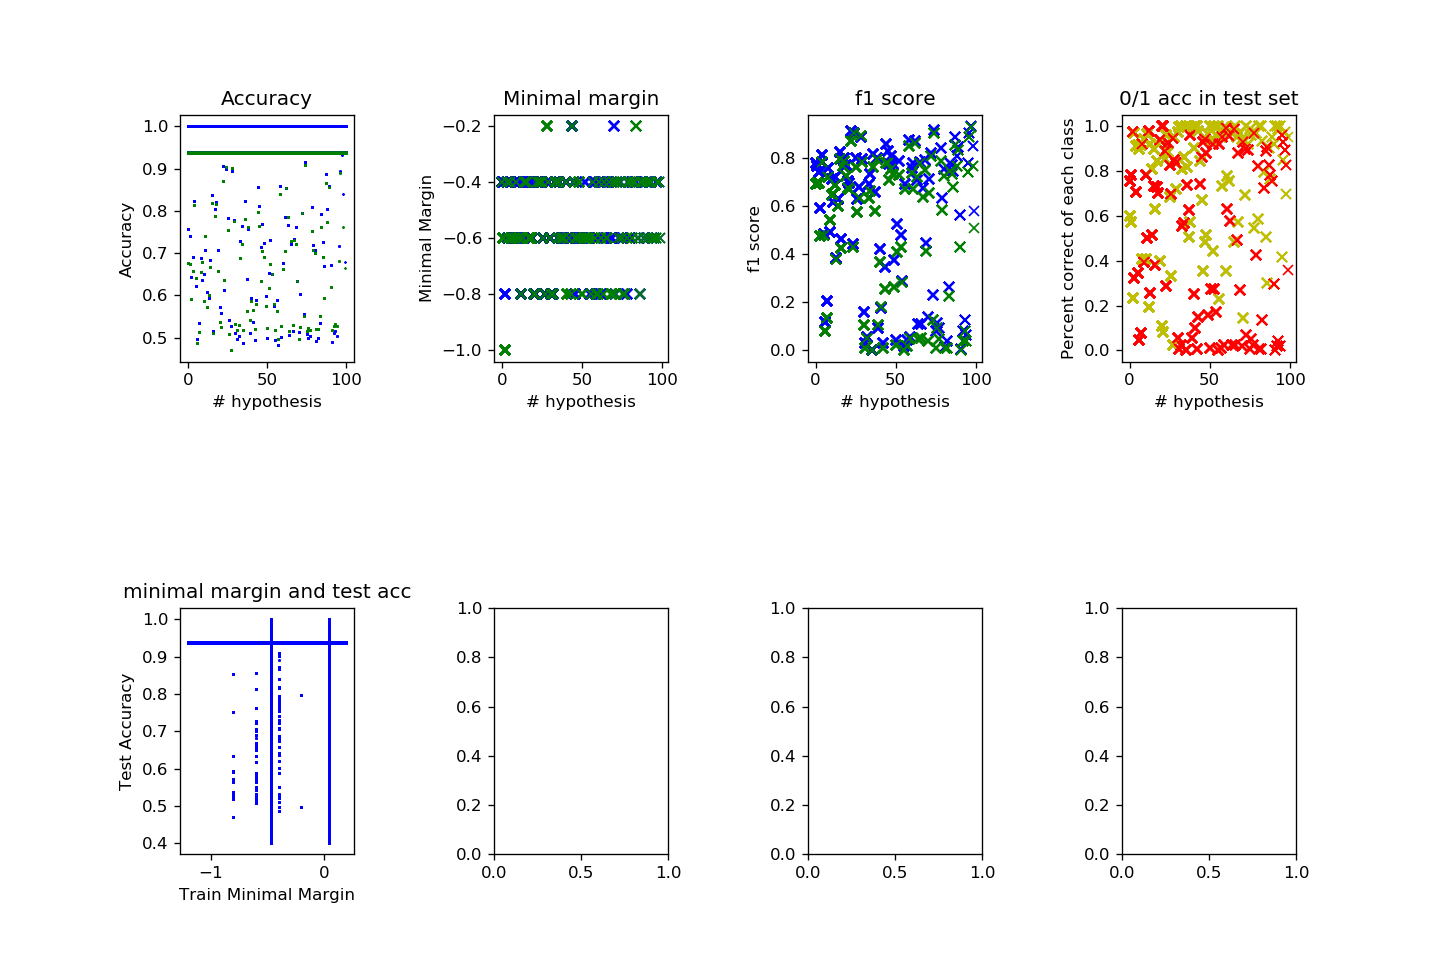

Ada_rs 	0.756667   0.675879   -0.400000  -0.400000  0.781437   0.692124   0.601942   0.755208   
Ada_rs 	0.740000   0.673367   -0.400000  -0.600000  0.769912   0.697674   0.572816   0.781250   
Ada_rs 	0.643333   0.590452   -0.800000  -1.000000  0.740920   0.696462   0.233010   0.973958   
Ada_rs 	0.691667   0.658291   -0.400000  -0.400000  0.591611   0.476923   0.970874   0.322917   
Ada_rs 	0.823333   0.814070   -0.600000  -0.600000  0.814035   0.786127   0.912621   0.708333   
Ada_rs 	0.621667   0.640704   -0.400000  -0.400000  0.482916   0.480000   0.917476   0.343750   
Ada_rs 	0.496667   0.487437   -0.400000  -0.600000  0.116959   0.081081   0.898058   0.046875   
Ada_rs 	0.535000   0.512563   -0.600000  -0.600000  0.205128   0.133929   0.917476   0.078125   
Ada_rs 	0.688333   0.655779   -0.600000  -0.600000  0.759949   0.720978   0.407767   0.921875   
Ada_rs 	0.636667   0.678392   -0.400000  -0.400000  0.493023   0.542857   0.941748   0.395833   
Ada_rs 	0.650000   0.587940   

/home/ubudevml/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Ada_rs 	0.488333   0.517588   -0.600000  -0.600000  0.000000   0.000000   1.000000   0.000000   
Ada_rs 	0.823333   0.781407   -0.400000  -0.400000  0.818493   0.765499   0.820388   0.739583   
Ada_rs 	0.638333   0.562814   -0.600000  -0.600000  0.659341   0.579710   0.504854   0.625000   
Ada_rs 	0.756667   0.761307   -0.600000  -0.600000  0.803235   0.795699   0.572816   0.963542   
Ada_rs 	0.511667   0.542714   -0.600000  -0.600000  0.092879   0.107843   0.995146   0.057292   
Ada_rs 	0.593333   0.587940   -0.400000  -0.400000  0.421801   0.369231   0.902913   0.250000   
Ada_rs 	0.536667   0.565327   -0.600000  -0.800000  0.177515   0.180095   1.000000   0.098958   
Ada_rs 	0.493333   0.520101   -0.600000  -0.600000  0.031847   0.010363   1.000000   0.005208   
Ada_rs 	0.590000   0.580402   -0.600000  -0.800000  0.345745   0.257778   0.980583   0.151042   
Ada_rs 	0.856667   0.796482   -0.200000  -0.200000  0.860841   0.779292   0.844660   0.744792   
Ada_rs 	0.811667   0.763819   

In [248]:
import copy
import time

def simplify_ada(ada, target): 
    # sample 'target' hypothesis
    count = ada.n_estimators
    probs = ada.estimator_weights_ / np.sum(ada.estimator_weights_)
    
    indx = np.random.choice(count, target, replace=False, p=probs) # should have replacements?
    new_weights = np.zeros(len(probs))
    for i in indx: new_weights[i] += 1
    ada.estimator_weights_ = new_weights / target
    
    return ada

def compute_matrix(ada, X, y):
    n, d = np.shape(X)
    
    # change from {0, 1} to {-1, 1}
    y = y*2-1
    
    # Normalize weights. 
    ada.estimator_weights_ = ada.estimator_weights_ / np.sum(ada.estimator_weights_)
    assert np.sum(ada.estimator_weights_) == 1, np.sum(ada.estimator_weights_)
    
    # 
    T = ada.n_estimators
    U = np.zeros((n, T))
    w = np.array(ada.estimator_weights_)
    
    # Add a column to U for each of all T hypothesis 
    for t in range(T):
        h = ada.estimators_[t]
        pred = h.predict(X) * 2 - 1 # change from {0, 1} to {-1, 1} # ERROR WAS HERE. 
        U[:,t] = pred * y           # * is entry wise multiplication.

    margins1 = U @ w
    
    # check minimal margin computation
    H = ada.decision_function(X)
    margins2 = H * y
    
    assert np.allclose(margins1, margins2)
    
    np.savetxt("U.txt", U, delimiter=" ", fmt="%.2f")
    np.savetxt("w.txt", w, delimiter=" ", fmt="%.10f")
    
    return U, w, np.min(margins1)
    

'''X, y = load_breast_cancer(True)
    
# randomly permute data. 
p = np.random.permutation(y.size)
X = X[p]
y = y[p]

# split data in same way as in adaboost (not that good coding style)
split = int(n*0.6)

X_train = X[:split]
y_train = y[:split]
X_test  = X[split+1: -1]
y_test  = y[split+1: -1]'''
n = 1000
d = 30

X, y = make_classification(n, d, n_classes=2)

split = int(n*0.6)

X_train = X[:split]
y_train = y[:split]
X_test  = X[split+1: -1]
y_test  = y[split+1: -1]
    
# print size and information of class sizes.
print(X.shape)
print(y.shape)
print("Class 0: ", round(sum(y==0)/y.size, 3))
print("Class 1: ", round(sum(y==1)/y.size, 3))

print("Name\t%-10s %-10s %-10s %-10s %-10s %-10s %-10s %-10s"%
          ("acc_train", "acc_test", "mm_in", "mm_test", "f1_train", "f1_test", "acc0_test", "acc1_test"))

target = 10
full = 500
depth = 1
repeats = 100

vals, ada_baseline  = ada_boost(X, y, depth, target)
print("Ada" + str(target), "\t%-10f %-10f %-10f %-10f %-10f %-10f %-10f %-10f "%(vals))
baseline_acc_train  = vals[0]
baseline_acc_test   = vals[1]
baseline_mm_train   = vals[2]
baseline_mm_test    = vals[3]
baseline_f1_train   = vals[4]
baseline_f1_test    = vals[5]
baseline_acc0_test  = vals[6]
baseline_acc1_test  = vals[7]

U, w, _ = compute_matrix(ada_baseline, X_train, y_train)


vals, ada_full = ada_boost(X, y, depth, full)
print("Ada" + str(full), "\t%-10f %-10f %-10f %-10f %-10f %-10f %-10f %-10f "%(vals))
full_acc_train  = vals[0]
full_acc_test   = vals[1]
full_mm_train   = vals[2]
full_mm_test    = vals[3]
full_f1_train   = vals[4]
full_f1_test    = vals[5]
full_acc0_test  = vals[6]
full_acc1_test  = vals[7]

U, w, _ = compute_matrix(ada_full, X_train, y_train)


# visualization stuff
plot_acc_train  = []
plot_acc_test   = []
plot_mm_train = []
plot_mm_test  = []
plot_f1_train = []
plot_f1_test  = []
plot_acc0_test = []
plot_acc1_test = []

fig, plots = plt.subplots(2, 4, figsize=(12,8)) 
(ax_acc, ax_margin, ax_f1, ax_acc01) = plots[0]
(ax_correlate, _, _, _) = plots[1]
fig.subplots_adjust(wspace=.8) #width space between subplots
fig.subplots_adjust(hspace=1.0) #width space between subplots
# end visualization stuff.

for i in range(repeats): 
    ada_rsample = simplify_ada(copy.deepcopy(ada_full), target)
    vals = test(X_train, X_test, y_train, y_test, ada_rsample)
    print("Ada_rs", "\t%-10f %-10f %-10f %-10f %-10f %-10f %-10f %-10f "%(vals))
    
    plot_acc_train.append(vals[0])
    plot_acc_test.append(vals[1])
    plot_mm_train.append(vals[2])
    plot_mm_test.append(vals[3])
    plot_f1_train.append(vals[4])
    plot_f1_test.append(vals[5])
    plot_acc0_test.append(vals[6])
    plot_acc1_test.append(vals[7])
    
    marker = 'x'

    ax_acc.plot(plot_acc_train, 'b' + marker, ms=1)
    ax_acc.plot(plot_acc_test, 'g' + marker, ms=1)
    ax_acc.plot([0, repeats], [baseline_acc_train, baseline_acc_train], 'b-', ms=1)
    ax_acc.plot([0, repeats], [baseline_acc_test,  baseline_acc_test],  'g-', ms=1)
    ax_acc.plot([0, repeats], [full_acc_train, full_acc_train], 'b-', ms=1)
    ax_acc.plot([0, repeats], [full_acc_test,  full_acc_test],  'g-', ms=1)
    ax_acc.set_title("Accuracy")
    ax_acc.set_xlabel("# hypothesis")
    ax_acc.set_ylabel("Accuracy")

    ax_margin.plot(plot_mm_train, 'b' + marker)
    ax_margin.plot(plot_mm_test, 'g' + marker)
    ax_margin.set_title("Minimal margin")
    ax_margin.set_xlabel("# hypothesis")
    ax_margin.set_ylabel("Minimal Margin")

    ax_f1.plot(plot_f1_train, 'b' + marker)
    ax_f1.plot(plot_f1_test, 'g' + marker)
    ax_f1.set_title("f1 score")
    ax_f1.set_xlabel("# hypothesis")
    ax_f1.set_ylabel("f1 score")

    ax_acc01.plot(plot_acc0_test, 'y' + marker)
    ax_acc01.plot(plot_acc1_test, 'r' + marker)
    ax_acc01.set_title("0/1 acc in test set")
    ax_acc01.set_xlabel("# hypothesis")
    ax_acc01.set_ylabel("Percent correct of each class")
    
    # do test error and minimal margin
    ax_correlate.plot(plot_mm_train, plot_acc_test, 'b' + marker, ms=1)
    
    ax_correlate.plot([-1.2, 0.2], [baseline_acc_test, baseline_acc_test], 'b-', ms=1)
    ax_correlate.plot([-1.2, 0.2], [full_acc_test, full_acc_test], 'b-', ms=1)
    ax_correlate.plot([baseline_mm_train, baseline_mm_train], [0.4, 1], 'b-', ms=1)
    ax_correlate.plot([full_mm_train, full_mm_train], [0.4, 1], 'b-', ms=1)
    
    ax_correlate.set_title("minimal margin and test acc")
    ax_correlate.set_xlabel("Train Minimal Margin")
    ax_correlate.set_ylabel("Test Accuracy")
    
    fig.canvas.draw()
    

# TODO:
# add baselines to plots
# add new plot that looks at minimal margin and error;; they should be correlated.
# plot best score with its own color?

# AirLine dataset

I tried downloadingg the dataset from Kaggle

In [166]:
import pandas as pd

def load_airline():
    t0 = time.time()
    print("Loading data...\t", end='')
    delayed_flighs = pd.read_csv("data/DelayedFlights.csv")
    print("DONE!", round(time.time()-t0, 4))
    print(delayed_flighs.shape)
    #print(delayed_flighs.head())
    print(delayed_flighs.columns)
    # remove all non numeric features
    
    
load_airline()


Loading data...	DONE! 5.7796
(1936758, 30)
Index(['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')


In [153]:
import time
import numpy as np
import pandas as pd

t0 = time.time()
print("Loading data...\t", end='')
d_train = pd.read_csv("data/train-0.1m.csv")
d_test = pd.read_csv("data/test.csv")
d_train_test = d_train.append(d_test)
print("DONE!", round(time.time()-t0, 4), "s")

vars_cat = ["Month","DayofMonth","DayOfWeek","UniqueCarrier", "Origin", "Dest"]
vars_num = ["DepTime","Distance"]
def my_get_dummies(d, col):
    dd = pd.get_dummies(d.ix[:, col])
    dd.columns = [col + "_%s" % c for c in dd.columns]
    return(dd)

t1 = time.time()
print("Manage data...\t", end='')
X_train_test_cat = pd.concat([my_get_dummies(d_train_test, col) for col in vars_cat], axis = 1)

X = pd.concat([X_train_test_cat, d_train_test.ix[:,vars_num]], axis = 1)
y = np.where(d_train_test["dep_delayed_15min"]=="Y", 1, 0)

print("DONE!", round(time.time()-t1, 4), "s")
print("Train Shape: \t", X_train.shape, y_train.shape)

# print size and information of class sizes.
print(X.shape)
print(y.shape)
print("Class 0: ", round(sum(y==0)/y.size, 3))
print("Class 1: ", round(sum(y==1)/y.size, 3))

Loading data...	DONE! 0.1646 s
Manage data...	

/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


DONE! 1.8343 s
Train Shape: 	 (341, 30) (341,)
(200000, 689)
(200000,)
Class 0:  0.797
Class 1:  0.203


<IPython.core.display.Javascript object>


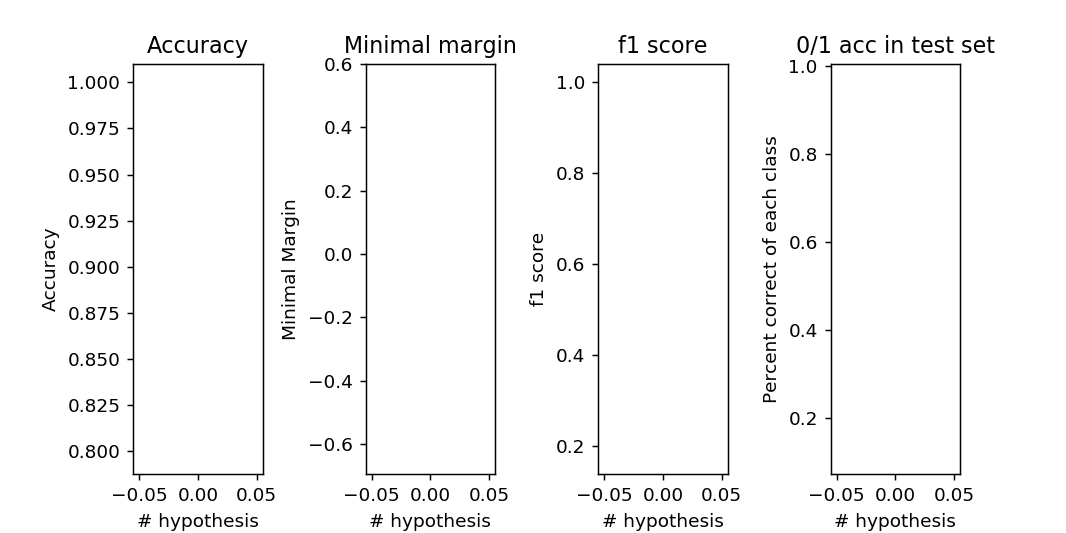

Iter.	acc_train  acc_test   mm_in      mm_test    f1_train   f1_test    acc0_test  acc1_test 
500 	1.000000   0.797649   0.541783   -0.636875  1.000000   0.178680   0.961849   0.113695   


In [154]:
experiment(X[:10000], y[:10000], 20, range(500, 501, 1))